In [2]:
import numpy as np
import pandas as pd

In [3]:
rf  = pd.read_csv("submission/submission_RF_model.csv")
xgb = pd.read_csv("submission/submission_xgboost.csv")
lgb = pd.read_csv("submission/submission_lightgbm.csv")

In [4]:
rf.head()

,ID,item_cnt_month
0,0,0.338588
1,1,0.059308
2,2,0.573056
3,3,0.342845
4,4,0.473250


In [5]:
y = pd.read_pickle("train_y.pickle")

In [6]:
%store -r train_pred
rf_train = train_pred   #从之前的 RF_model 中共享变量

array([ 2.61450497,  0.97720469,  1.69136638, ...,  0.05930815,
        0.05930815,  0.05930815])

In [7]:
%store -r lgb_train

In [8]:
lgb_train

array([ 2.71634617,  1.04346243,  1.52931851, ...,  0.0823797 ,
        0.05239325,  0.04962146])

In [9]:
%store -r xgb_train

In [10]:
xgb_train

array([ 2.50225759,  0.98120594,  1.44784737, ...,  0.1105054 ,
        0.07139453,  0.06060559], dtype=float32)

In [11]:
train_level2 = pd.DataFrame()

In [12]:
train_level2["lgb"] = lgb_train
train_level2["rf"] = rf_train
train_level2["xgb"] = xgb_train

In [13]:
train_level2 = train_level2.drop("average", axis = 1)

ValueError: labels ['average'] not contained in axis

In [14]:
train_level2.shape

(2485577, 3)

In [64]:
train_level2.to_pickle("stack_level2/train_level2_lgb+rf+xgb.pickle")

In [37]:
y[:5]

8428273    2.0
8428274    1.0
8428275    3.0
8428276    1.0
8428277    1.0
Name: target, dtype: float32

In [40]:
test_level2 = pd.DataFrame()
test_level2["lgb"] = lgb["item_cnt_month"]
test_level2["rf"]  = rf["item_cnt_month"]
test_level2["xgb"] = xgb["item_cnt_month"]
test_level2.head()

,lgb,rf,xgb
0,0.299282,0.338588,0.281057
1,0.198649,0.059308,0.164724
2,0.763837,0.573056,0.579070
3,0.406244,0.342845,0.375013
4,1.955830,0.473250,2.041888


# Just average 

In [30]:
train_level2["average"] = 0.8*rf["item_cnt_month"] + 0.1*xgb["item_cnt_month"] + 0.1*lgb["item_cnt_month"]

In [31]:
sample = pd.read_csv("../sample_submission.csv")
sample["item_cnt_month"] = train_level2["average"]
sub = sample
sub.to_csv("submission/submission_average_3model.csv", index = False)

In [22]:
!pwd

/Users/ch/PycharmProjects/predict_future_sales/predict_for_sales


In [32]:
!kaggle competitions submit -c competitive-data-science-predict-future-sales -f submission/submission_average_3model.csv -m "Message"


Successfully submitted to Predict Future Sales

#  Linear regression

In [25]:
from sklearn.linear_model import Ridge, LinearRegression

In [38]:
from sklearn.metrics import make_scorer
lr = LinearRegression()
lr.fit(train_level2, y.values)

/Library/Frameworks/Python.framework/Versions/3.5/lib/python3.5/site-packages/scipy/linalg/basic.py:1018: RuntimeWarning: internal gelsd driver lwork query error, required iwork dimension not returned. This is likely the result of LAPACK bug 0038, fixed in LAPACK 3.2.2 (released July 21, 2010). Falling back to 'gelss' driver.
  warnings.warn(mesg, RuntimeWarning)


LinearRegression(copy_X=True, fit_intercept=True, n_jobs=1, normalize=False)

In [39]:
lr.coef_

array([ 1.47445027, -0.37059922, -0.1148474 ])

In [45]:
test_y_level2 = lr.predict(test_level2)
test_y_level2

array([ 0.28662782,  0.25511141,  0.85047199, ...,  0.11462403,
        0.04973832,  0.01486799])

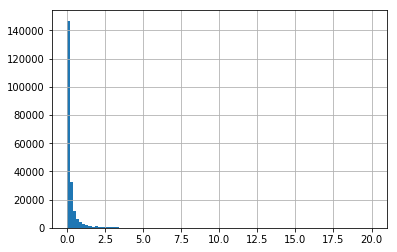

In [47]:
test_y_level2 = np.clip(test_y_level2,0,20)
pd.Series(test_y_level2).hist(bins = 100)

In [49]:
sample = pd.read_csv("../sample_submission.csv")
sample["item_cnt_month"] = test_y_level2
sub = sample
sub.to_csv("submission/submission_lr_regression_3models.csv", index = False)
sub.head()

,ID,item_cnt_month
0,0,0.286628
1,1,0.255111
2,2,0.850472
3,3,0.431970
4,4,2.476993


In [15]:
!kaggle competitions submit -c competitive-data-science-predict-future-sales -f submission/submission_lr_regression_3models.csv -m "Message"


2018-09-07 20:17:23,354 WARNING Retrying (Retry(total=2, connect=None, read=None, redirect=None, status=None)) after connection broken by 'NewConnectionError('<urllib3.connection.VerifiedHTTPSConnection object at 0x10ca46668>: Failed to establish a new connection: [Errno 8] nodename nor servname provided, or not known',)': /api/v1/competitions/submissions/url/5646976/1536206664617
^C


#  Ridge regression 

In [51]:
params = {
    "alpha":0,
    "fit_intercept":False,
    "solver":"sag",
    "random_state":1402
}
ridge = Ridge(**params)
ridge.fit(train_level2, y.values)

Ridge(alpha=0, copy_X=True, fit_intercept=False, max_iter=None,
   normalize=False, random_state=1402, solver='sag', tol=0.001)

In [52]:
ridge.coef_

array([ 1.47411452, -0.36866898, -0.11531734])

The coef is just the same as the linear regression, skip this model

# Random forest 

In [53]:
from sklearn.ensemble import RandomForestRegressor

In [54]:
RF_model = RandomForestRegressor(n_estimators=10, min_samples_leaf=100)
RF_model.fit(train_level2, y.values)

RandomForestRegressor(bootstrap=True, criterion='mse', max_depth=None,
           max_features='auto', max_leaf_nodes=None,
           min_impurity_decrease=0.0, min_impurity_split=None,
           min_samples_leaf=100, min_samples_split=2,
           min_weight_fraction_leaf=0.0, n_estimators=10, n_jobs=1,
           oob_score=False, random_state=None, verbose=0, warm_start=False)

In [55]:
test_y_level2 = RF_model.predict(test_level2)
test_y_level2

array([ 0.30804228,  0.24712038,  0.84649849, ...,  0.08429253,
        0.02893993,  0.03177118])

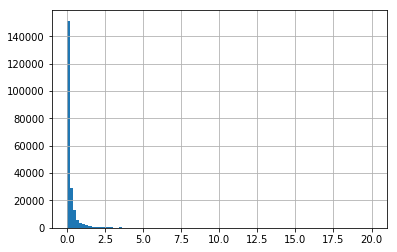

In [56]:
pd.Series(test_y_level2).hist(bins = 100)

In [59]:
def submit(arr):
    sample = pd.read_csv("../sample_submission.csv")
    sample["item_cnt_month"] = arr
    sub = sample
    sub.to_csv("submission/submission_RF_3models.csv", index = False)
    return sub

In [60]:
sub = submit(test_y_level2)

In [61]:
sub.head()

,ID,item_cnt_month
0,0,0.286628
1,1,0.255111
2,2,0.850472
3,3,0.431970
4,4,2.476993


In [63]:
!kaggle competitions submit -c competitive-data-science-predict-future-sales -f submission/submission_RF_3models.csv -m "Message"


Successfully submitted to Predict Future Sales